In [ ]:
import sys
from pathlib import Path
# set the notebook's CWD to your repo root
%cd D:/deepdemand
ROOT = Path.cwd().parents[0]   # go up one level
sys.path.insert(0, str(ROOT))


In [ ]:
#!/usr/bin/env python3
"""
Compute O-score and D-score for each LSOA using the trained DeepDemand encoders + pair scorer.

Definitions (for N LSOAs indexed i = 0..N-1):

  s_{i,j} = pair_score( enc_O(i), enc_D(j) )  >= 0

Then:

  O_score(i) = (1 / (N-1)) * sum_{j != i} s_{i,j}
  D_score(i) = (1 / (N-1)) * sum_{j != i} s_{j,i}

This script:
  - Loads LSOA features
  - Applies PCA with the saved pca_model_lsoa21.npz (if present)
  - Loads enc_O, enc_D, pair_head weights from a DeepDemand checkpoint
  - Computes all pair scores in blocks
  - Aggregates to O_score and D_score
  - Saves results to CSV and NPY.
"""

import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from config import MODEL           # uses MODEL['node_hidden'], ['node_out'], ['pair_hidden']
from model.dataloader import load_json, get_lsoa_vector

# -----------------------------
# User paths / config
# -----------------------------
CKPT_PATH   = "param/cv_0/best_stage_1_lr1e-03.pt"   # <- change if needed
LSOA_JSON   = "data/node_features/lsoa21_features_normalized.json"
PCA_MODEL   = "data/node_features/pca_model_lsoa21.npz"   # saved by trainer if PCA was used

OUT_DIR     = "interpret/OD_scores"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

# Block sizes for pair scoring (tune for memory/perf)
BLOCK_I = 64      # number of origins per block
BLOCK_J = 512     # number of destinations per block


# -----------------------------
# Minimal MLP (matches training)
# -----------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.1, act=nn.ReLU):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), act(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class DeepDemandLitePair(nn.Module):
    """
    Only the LSOA encoders + pair_head + Softplus, matching the trained DeepDemand pieces.
    """
    def __init__(self, lsoa_dim: int):
        super().__init__()
        self.enc_O     = MLP(lsoa_dim, MODEL['node_hidden'], MODEL['node_out'])
        self.enc_D     = MLP(lsoa_dim, MODEL['node_hidden'], MODEL['node_out'])
        self.pair_head = MLP(2 * MODEL['node_out'], MODEL['pair_hidden'], 1)
        self.softplus  = nn.Softplus()

    def pair_score_block(self, EO_block: torch.Tensor, ED_block: torch.Tensor) -> torch.Tensor:
        """
        EO_block: [Bi, d]
        ED_block: [Bj, d]
        Returns:
            S: [Bi, Bj] with non-negative pair scores.
        """
        Bi, d = EO_block.shape
        Bj, _ = ED_block.shape

        # shape [Bi, Bj, d]
        EO_rep = EO_block.unsqueeze(1).expand(-1, Bj, -1)
        ED_rep = ED_block.unsqueeze(0).expand(Bi, -1, -1)

        x = torch.cat([EO_rep, ED_rep], dim=-1)      # [Bi, Bj, 2d]
        x_flat = x.reshape(Bi * Bj, 2 * d)           # [Bi*Bj, 2d]

        z = self.pair_head(x_flat).squeeze(-1)       # [Bi*Bj]
        s = self.softplus(z).reshape(Bi, Bj)         # [Bi, Bj] >= 0
        return s


# -----------------------------
# PCA helper
# -----------------------------
def maybe_pca_project(X: np.ndarray, pca_npz_path: str) -> np.ndarray:
    """
    If PCA model exists, project X using saved mean/components.
    Else return X unchanged.
    """
    if not os.path.isfile(pca_npz_path):
        print(f"[PCA] No PCA model found at {pca_npz_path} -> using raw features.")
        return X
    npz = np.load(pca_npz_path, allow_pickle=True)
    mean = npz["mean"].astype(np.float32)         # (F,)
    comps = npz["components"].astype(np.float32)  # (k, F)
    Xc = X - mean
    Xp = Xc @ comps.T                             # (N, k)
    print(f"[PCA] Projected to shape {Xp.shape} using saved model.")
    return Xp.astype(np.float32)


# -----------------------------
# 1) Load LSOA features (raw)
# -----------------------------
lsoa_json = load_json(LSOA_JSON)
lsoa_codes = sorted(lsoa_json.keys())

rows = []
for code in lsoa_codes:
    vec = get_lsoa_vector(lsoa_json[code])  # torch tensor (F_raw,)
    rows.append(vec.cpu().numpy())

X_raw = np.vstack(rows).astype(np.float32)        # (N, F_raw)
N, F_raw = X_raw.shape
print(f"[Data] Raw LSOA feature matrix: {X_raw.shape}")

# -----------------------------
# 2) Apply PCA (if model exists)
# -----------------------------
X_in = maybe_pca_project(X_raw, PCA_MODEL)
in_dim = X_in.shape[1]
print(f"[Data] Input dim to encoders: {in_dim}")


# -----------------------------
# 3) Instantiate model & load weights
# -----------------------------
model = DeepDemandLitePair(lsoa_dim=in_dim).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location="cpu")
state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

lite_sd = model.state_dict()
# Keep only matching keys (enc_O.*, enc_D.*, pair_head.*)
filtered = {k: v for k, v in state_dict.items()
            if k in lite_sd and lite_sd[k].shape == v.shape}
lite_sd.update(filtered)
missing = [k for k in lite_sd.keys() if k not in filtered]
print(f"[Load] Loaded {len(filtered)} keys into DeepDemandLitePair; "
      f"{len(missing)} keys left as init (e.g., softplus/no-unused).")
model.load_state_dict(lite_sd)
model.eval()

# -----------------------------
# 4) Encode all LSOAs
# -----------------------------
with torch.no_grad():
    X_t = torch.from_numpy(X_in).to(DEVICE)        # (N, in_dim)
    EO = model.enc_O(X_t)                          # (N, d)
    ED = model.enc_D(X_t)                          # (N, d)

print(f"[Emb] EO: {EO.shape}, ED: {ED.shape}")

# -----------------------------
# 5) Compute all pair scores in blocks, aggregate to O/D scores
# -----------------------------
O_sum  = np.zeros(N, dtype=np.float64)   # sum over j of s_{i,j}
D_sum  = np.zeros(N, dtype=np.float64)   # sum over i of s_{i,j} -> s_{j,i}
diag   = np.zeros(N, dtype=np.float64)   # s_{i,i}, to exclude later

print("[Pair] Computing pair scores blockwise...")

with torch.no_grad():
    for start_i in range(0, N, BLOCK_I):
        end_i = min(start_i + BLOCK_I, N)
        EO_block = EO[start_i:end_i]         # [Bi, d]
        Bi = end_i - start_i
        idx_i_global = np.arange(start_i, end_i)

        for start_j in range(0, N, BLOCK_J):
            end_j = min(start_j + BLOCK_J, N)
            ED_block = ED[start_j:end_j]     # [Bj, d]
            Bj = end_j - start_j
            idx_j_global = np.arange(start_j, end_j)

            # scores_block: [Bi, Bj]
            scores_block = model.pair_score_block(EO_block, ED_block)
            scores_np = scores_block.cpu().numpy().astype(np.float64)

            # row / col sums
            row_sums = scores_np.sum(axis=1)     # [Bi]
            col_sums = scores_np.sum(axis=0)     # [Bj]

            O_sum[idx_i_global] += row_sums
            D_sum[idx_j_global] += col_sums

            # accumulate diagonal terms where global_i == global_j
            for local_i, g_i in enumerate(idx_i_global):
                if g_i < start_j or g_i >= end_j:
                    continue
                local_j = g_i - start_j
                diag[g_i] += scores_np[local_i, local_j]

# -----------------------------
# 6) Convert sums to averages, excluding self-pairs
# -----------------------------
denom = float(N - 1)
O_score = (O_sum - diag) / denom
D_score = (D_sum - diag) / denom

print("[Pair] Done. Basic stats:")
print(f"  O_score: min={O_score.min():.4f}, max={O_score.max():.4f}, mean={O_score.mean():.4f}")
print(f"  D_score: min={D_score.min():.4f}, max={D_score.max():.4f}, mean={D_score.mean():.4f}")

# -----------------------------
# 7) Save results
# -----------------------------
# Numpy arrays
np.save(Path(OUT_DIR) / "O_score.npy", O_score)
np.save(Path(OUT_DIR) / "D_score.npy", D_score)
np.save(Path(OUT_DIR) / "LSOA_codes.npy", np.array(lsoa_codes, dtype=object))

# CSV
df = pd.DataFrame({
    "lsoa_code": lsoa_codes,
    "O_score": O_score,
    "D_score": D_score,
})
csv_path = Path(OUT_DIR) / "O_D_scores.csv"
df.to_csv(csv_path, index=False)
print(f"[Save] Wrote:\n  - {OUT_DIR}/O_score.npy\n  - {OUT_DIR}/D_score.npy\n  - {csv_path}")

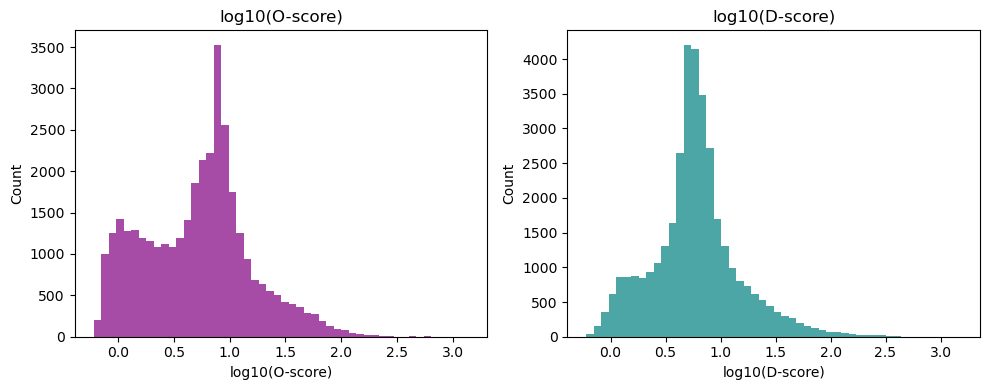

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Load arrays
# ------------------------------
O_score = np.load("interpret/OD_scores/O_score.npy")
D_score = np.load("interpret/OD_scores/D_score.npy")

# Replace zeros (log undefined)
eps = 1e-12
O_log = np.log10(O_score + eps)
D_log = np.log10(D_score + eps)

# ------------------------------
# Plot log10 histograms
# ------------------------------
plt.figure(figsize=(10,4))

# O-score log10
plt.subplot(1,2,1)
plt.hist(O_log, bins=50, color="purple", alpha=0.7)
plt.title("log10(O-score)")
plt.xlabel("log10(O-score)")
plt.ylabel("Count")

# D-score log10
plt.subplot(1,2,2)
plt.hist(D_log, bins=50, color="teal", alpha=0.7)
plt.title("log10(D-score)")
plt.xlabel("log10(D-score)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [6]:
#!/usr/bin/env python3
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import folium
from folium.features import GeoJson, GeoJsonTooltip

# ============ INPUTS ============
LSOA_SHP = (
    "../data/node_features/boundaries/Lower layer Super Output Areas (December 2021) Boundaries EW BFC (V10)/"
    "Lower_layer_Super_Output_Areas_December_2021_Boundaries_EW_BFC_V10_8562115581115271145/"
    "LSOA_2021_EW_BFC_V10.shp"
)

EMB_DIR = "OD_scores"
O_SCORE_FILE = os.path.join(EMB_DIR, "O_score.npy")
D_SCORE_FILE = os.path.join(EMB_DIR, "D_score.npy")
CODE_FILE    = os.path.join(EMB_DIR, "LSOA_codes.npy")

OUT_O_PDF  = os.path.join(EMB_DIR, "map_O_score_quintiles.pdf")
OUT_D_PDF  = os.path.join(EMB_DIR, "map_D_score_quintiles.pdf")

OUT_O_HTML = os.path.join(EMB_DIR, "map_O_score_top3quintiles_overlay.html")
OUT_D_HTML = os.path.join(EMB_DIR, "map_D_score_top3quintiles_overlay.html")

# HTML style
HTML_ALPHA = 0.55
LINE_WEIGHT = 0.2
LINE_OPACITY = 0.15
TILES = "cartodbpositron"

# Quintiles: 1..5, top-3 are 3,4,5
TOP_QUINTILES = {3, 4, 5}

# ========================= LOAD SCORES =========================
O_score = np.load(O_SCORE_FILE).astype(float)
D_score = np.load(D_SCORE_FILE).astype(float)
codes   = np.load(CODE_FILE, allow_pickle=True).astype(str)

# ========================= LOAD SHAPEFILE =========================
gdf = gpd.read_file(LSOA_SHP)
if gdf.crs is None:
    raise ValueError("Shapefile missing CRS.")

# Keep an area CRS for density
gdf_area = gdf.to_crs(27700) if gdf.crs.to_epsg() != 27700 else gdf.copy()
gdf_area["area_km2"] = gdf_area.geometry.area / 1e6

# Web CRS for HTML
gdf_web = gdf.to_crs(4326)

# ========================= FIND CODE COLUMN =========================
candidate_cols = ["LSOA21CD", "lsoa21cd", "lsoa11cd", "LSOA_CODE", "code"]
key_col = next((c for c in candidate_cols if c in gdf.columns), None)
if key_col is None:
    raise ValueError("Could not locate LSOA code field.")

# ========================= PALETTE (use the 5 colors you left) =========================
# You left 5 colors keyed by deciles (2,4,5,8,10). Re-map them to quintiles 1..5.
# Quintile 1 (lowest)  -> former 2
# Quintile 2           -> former 4
# Quintile 3           -> former 5
# Quintile 4           -> former 8
# Quintile 5 (highest) -> former 10
quintile_colors = {
    1:  "#08519c",
    2:  "#4292c6",
    3:  "#ffffb2",
    4:  "#fd8d3c",
    5:  "#bd0026",
}

# ============ Function to build one PDF map (quintiles) ============
def plot_quintile_pdf(score_vec, out_pdf):
    df_scores = pd.DataFrame({key_col: codes, "score": score_vec})
    gdf2 = gdf_area.merge(df_scores, on=key_col, how="left")
    gdf2["score_density"] = gdf2["score"] / gdf2["area_km2"]

    vals = gdf2["score_density"].to_numpy()
    mask = np.isfinite(vals)
    v = vals[mask]

    try:
        gdf2.loc[mask, "quintile"] = pd.qcut(v, 5, labels=False, duplicates="drop") + 1
    except Exception:
        gdf2["quintile"] = 1

    gdf2.loc[~mask, "quintile"] = 0
    gdf2["quintile"] = gdf2["quintile"].astype(int)

    gdf2["color"] = gdf2["quintile"].map(quintile_colors)

    fig, ax = plt.subplots(figsize=(7, 8))
    gdf2.plot(color=gdf2["color"], linewidth=0.05, edgecolor="none", ax=ax)
    ax.set_axis_off()
    plt.tight_layout()

    os.makedirs(os.path.dirname(out_pdf), exist_ok=True)
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.close()
    print(f"Saved: {out_pdf}")

# ============ Function to build HTML overlay map (ONLY top 3 quintiles) ============
def plot_top3quintiles_html(score_vec, out_html, layer_name):
    df_scores = pd.DataFrame({key_col: codes, "score": score_vec})
    g2 = gdf_area.merge(df_scores, on=key_col, how="left")
    g2["score_density"] = g2["score"] / g2["area_km2"]

    vals = g2["score_density"].to_numpy()
    mask = np.isfinite(vals)
    v = vals[mask]

    try:
        g2.loc[mask, "quintile"] = pd.qcut(v, 5, labels=False, duplicates="drop") + 1
    except Exception:
        g2["quintile"] = 1

    g2.loc[~mask, "quintile"] = 0
    g2["quintile"] = g2["quintile"].astype(int)

    # ---- KEEP ONLY TOP 3 QUINTILES (do not embed other geometries) ----
    g2 = g2[g2["quintile"].isin(TOP_QUINTILES)].copy()

    # Bring geometry to web CRS for folium
    g2 = g2.drop(columns=["geometry"]).join(gdf_web[["geometry"]], how="left")
    g2 = gpd.GeoDataFrame(g2, geometry="geometry", crs=4326)

    # Reduce payload
    g2["score_density"] = g2["score_density"].round(3)
    g2 = g2[[key_col, "quintile", "score_density", "geometry"]]

    # Center map based on full study area
    full_bounds = gdf_web.total_bounds
    center_lat = (full_bounds[1] + full_bounds[3]) / 2.0
    center_lon = (full_bounds[0] + full_bounds[2]) / 2.0

    m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles=TILES, control_scale=True)

    def style_fn(feat):
        q = feat["properties"].get("quintile", 0)
        fill = quintile_colors.get(q, "#000000")
        return {
            "fillColor": fill,
            "color": "#000000",
            "weight": LINE_WEIGHT,
            "opacity": LINE_OPACITY,
            "fillOpacity": HTML_ALPHA,
        }

    tooltip = GeoJsonTooltip(
        fields=[key_col, "quintile", "score_density"],
        aliases=["LSOA", "Quintile", "Score density"],
        localize=True,
        sticky=False,
        labels=True,
        style=("background-color: white; color: #111; font-size: 12px; padding: 6px;")
    )

    gj = GeoJson(
        data=json.loads(g2.to_json()),
        name=layer_name,
        style_function=style_fn,
        tooltip=tooltip,
    )
    gj.add_to(m)

    folium.LayerControl(collapsed=True).add_to(m)

    os.makedirs(os.path.dirname(out_html), exist_ok=True)
    m.save(out_html)
    print(f"Saved: {out_html} (features embedded: {len(g2)})")

# ========================= PRODUCE OUTPUTS =========================
plot_quintile_pdf(O_score, OUT_O_PDF)
plot_quintile_pdf(D_score, OUT_D_PDF)

plot_top3quintiles_html(O_score, OUT_O_HTML, "O score (top 3 quintiles)")
plot_top3quintiles_html(D_score, OUT_D_HTML, "D score (top 3 quintiles)")

print("All PDF + top-quintiles HTML overlay maps generated.")

Saved: OD_scores\map_O_score_quintiles.pdf
Saved: OD_scores\map_D_score_quintiles.pdf
Saved: OD_scores\map_O_score_top3quintiles_overlay.html (features embedded: 21403)
Saved: OD_scores\map_D_score_top3quintiles_overlay.html (features embedded: 21403)
All PDF + top-quintiles HTML overlay maps generated.


In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
import numpy as np

def plot_quintile_legend_only(
    out_file,
    title="Score density quintile",
    figsize=(2.2, 2.5)
):
    # Ensure consistent order: Q1 -> Q5
    colors = [
        quintile_colors[1],
        quintile_colors[2],
        quintile_colors[3],
        quintile_colors[4],
        quintile_colors[5],
    ]

    cmap = ListedColormap(colors)
    bounds = np.arange(1, 7)  # 1..5 + upper bound
    norm = BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_alpha(0.0)
    ax.axis("off")

    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=ax,
        orientation="vertical",
        fraction=0.8,
        pad=0.02,
        ticks=[1.5, 2.5, 3.5, 4.5, 5.5],
    )

    cbar.ax.set_yticklabels([
        "Q1 (lowest)",
        "Q2",
        "Q3",
        "Q4",
        "Q5 (highest)",
    ])

    cbar.set_label(title)

    plt.savefig(out_file, bbox_inches="tight", transparent=True)
    plt.close()
    print(f"Saved legend: {out_file}")

plot_quintile_legend_only(
    out_file=os.path.join(EMB_DIR, "quintile_legend.svg")
)

Saved legend: OD_scores\quintile_legend.svg
